# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-08-14

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# 2. 데이터 확인

In [2]:
olist_db = "../data/olist_database.db"
conn = sqlite3.connect(olist_db)

In [3]:
cursor = conn.cursor()

In [ ]:
query_products = "SELECT * FROM olist_products_dataset"
df_products = pd.read_sql_query(query_products, conn)
df_products

In [ ]:
query_items = "SELECT * FROM olist_order_items_dataset"
df_items = pd.read_sql_query(query_items, conn)
df_items

In [ ]:
query_orders = "SELECT * FROM olist_orders_dataset"
df_orders = pd.read_sql_query(query_orders, conn)
df_orders

In [ ]:
query_reviews = "SELECT * FROM olist_order_reviews_dataset"
df_reviews = pd.read_sql_query(query_reviews, conn)
df_reviews

# 3. 데이터 정제

## 카테고리 이름 포르투갈 -> 영어 대치

In [ ]:
# 영어 번역 컬럼 추가
new_col_query = """
ALTER TABLE olist_products_dataset
ADD COLUMN product_category_name_english VARCHAR(255)
"""
cursor.execute(new_col_query)
conn.commit()

In [ ]:
# 영어 번역 데이터로 업데이트
p2e_query = """
UPDATE olist_products_dataset
SET product_category_name_english = (
    SELECT pct.product_category_name_english
    FROM product_category_name_translation pct
    WHERE TRIM(LOWER(olist_products_dataset.product_category_name)) = TRIM(LOWER(pct.product_category_name))
)
WHERE EXISTS (
    SELECT 1
    FROM product_category_name_translation pct
    WHERE TRIM(LOWER(olist_products_dataset.product_category_name)) = TRIM(LOWER(pct.product_category_name))
)
"""
cursor.execute(p2e_query)
conn.commit()

In [ ]:
# 기존 컬럼 삭제
drop_col_query = """
ALTER TABLE olist_products_dataset
DROP COLUMN product_category_name
"""
cursor.execute(drop_col_query)
conn.commit()

In [ ]:
# 데이터 조회
query = "SELECT * FROM olist_products_dataset"
df_products_new = pd.read_sql_query(query, conn)
df_products_new

# 4. 시각화

## 카테고리별 제품 개수

In [4]:
query = """
SELECT
    product_category_name_english,
    COUNT(*) AS product_count
FROM
    olist_products_dataset
GROUP BY
    product_category_name_english
ORDER BY
    product_count DESC
"""

df_category_counts = pd.read_sql_query(query, conn)
df_category_counts

,product_category_name_english,product_count
0,bed_bath_table,3029
1,sports_leisure,2867
2,furniture_decor,2657
3,health_beauty,2444
4,housewares,2335
...,...,...
67,tablets_printing_image,9
68,home_comfort_2,5
69,fashion_childrens_clothes,5
70,security_and_services,2


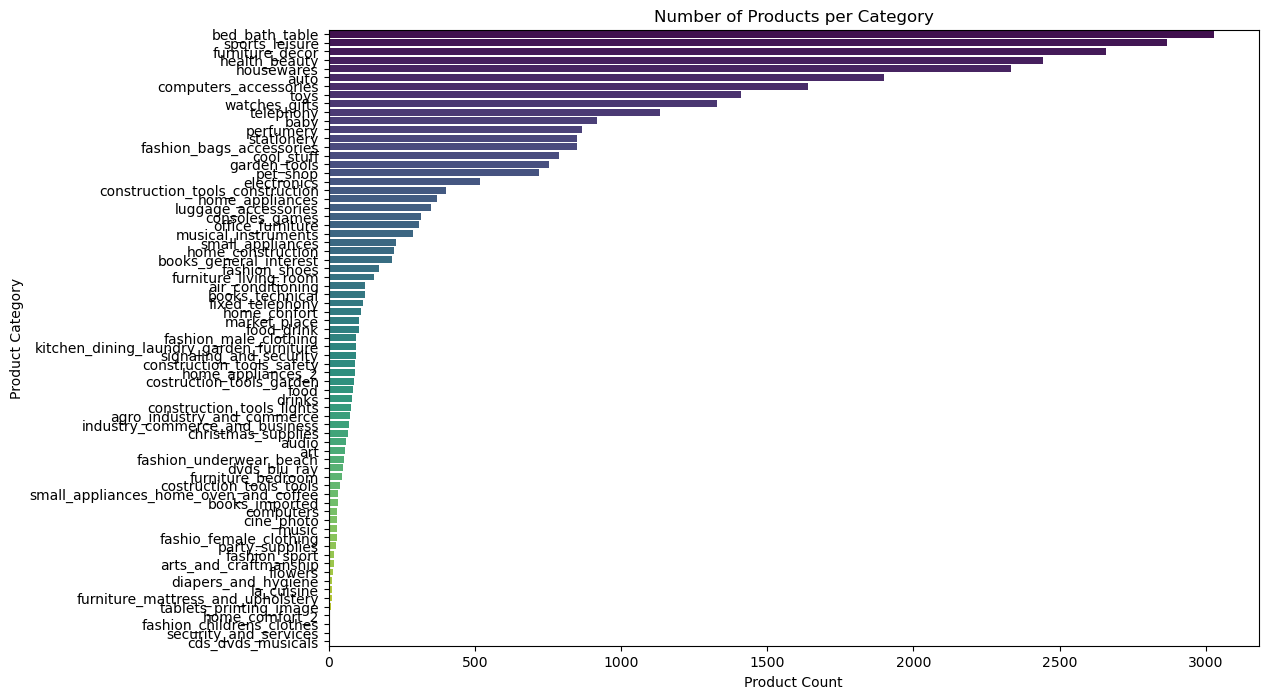

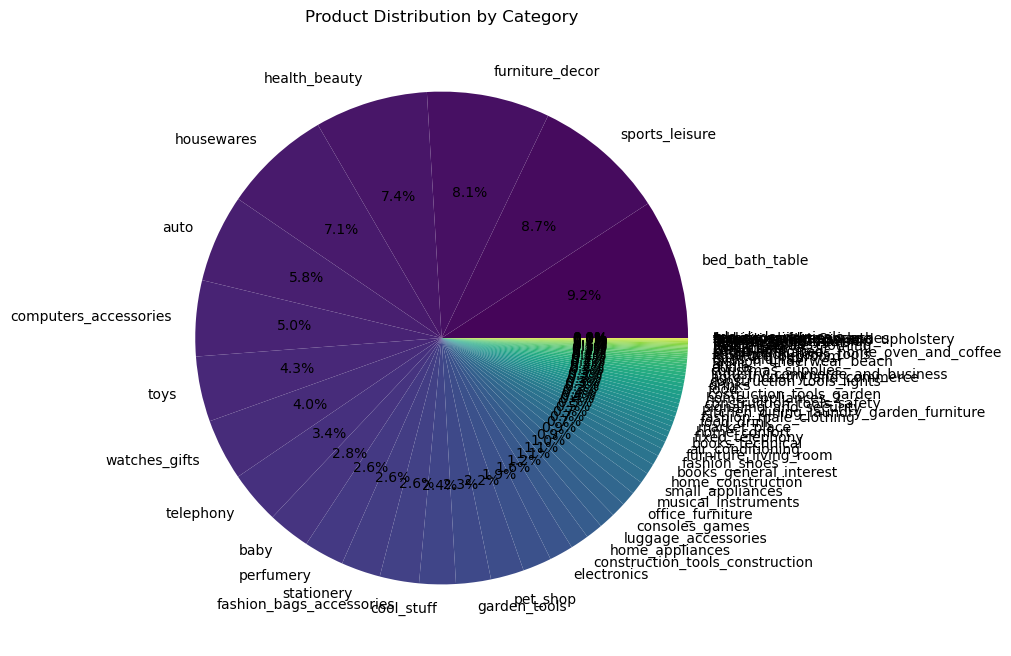

In [5]:
# 바 차트 시각화
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='product_count', y='product_category_name_english', data=df_category_counts, palette='viridis')
bar_plot.set_title('Number of Products per Category')
bar_plot.set_xlabel('Product Count')
bar_plot.set_ylabel('Product Category')
plt.show()

# 파이 차트 시각화
plt.figure(figsize=(10, 8))
plt.pie(df_category_counts['product_count'], labels=df_category_counts['product_category_name_english'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df_category_counts)))
plt.title('Product Distribution by Category')
plt.show()

## 시계열 데이터 시각화

In [6]:
# 리뷰 작성일 데이터 가져오기
review_query = """
SELECT review_answer_timestamp
FROM olist_order_reviews_dataset
WHERE review_answer_timestamp BETWEEN '2017-08-28 00:00:00' AND '2018-08-26 23:59:59'
"""
reviews_ts = pd.read_sql_query(review_query, conn)

# 주문 타임스탬프 데이터 가져오기
order_query = """
SELECT order_purchase_timestamp
FROM olist_orders_dataset
WHERE order_purchase_timestamp BETWEEN '2017-08-28 00:00:00' AND '2018-08-26 23:59:59'
"""
orders_ts = pd.read_sql_query(order_query, conn)

In [7]:
# 데이터 프레임을 datetime 형식으로 변환
reviews_ts['review_answer_timestamp'] = pd.to_datetime(reviews_ts['review_answer_timestamp'])
orders_ts['order_purchase_timestamp'] = pd.to_datetime(orders_ts['order_purchase_timestamp'])

# 시계열별 개수 계산
review_counts = reviews_ts['review_answer_timestamp'].dt.to_period('D').value_counts().sort_index()
order_counts = orders_ts['order_purchase_timestamp'].dt.to_period('D').value_counts().sort_index()

# 시계열 데이터프레임으로 변환
review_counts_df = review_counts.reset_index()
review_counts_df.columns = ['Date', 'Review_Count']
order_counts_df = order_counts.reset_index()
order_counts_df.columns = ['Date', 'Order_Count']

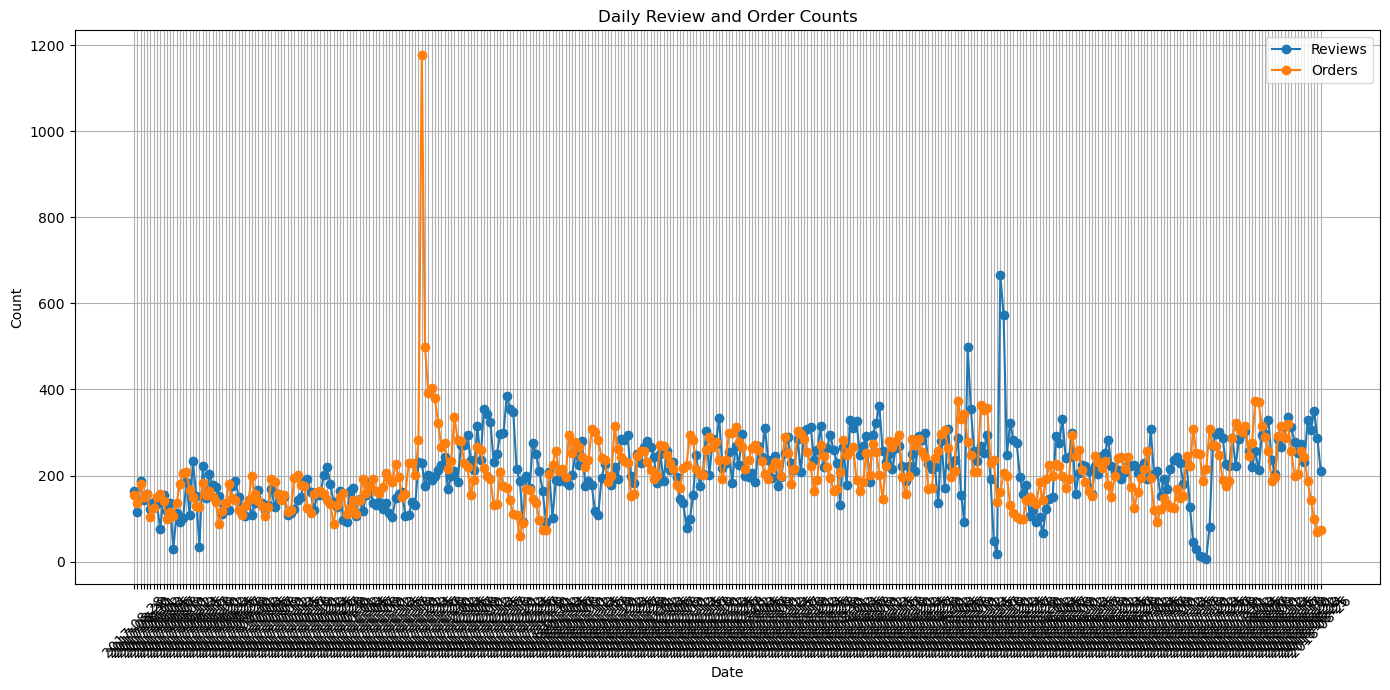

In [8]:
# 시계열 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(review_counts_df['Date'].astype(str), review_counts_df['Review_Count'], label='Reviews', marker='o')
plt.plot(order_counts_df['Date'].astype(str), order_counts_df['Order_Count'], label='Orders', marker='o')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Review and Order Counts')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()